# FolkTables Data

Folktables provides the following pre-defined prediction tasks:

***ACSIncome***: predict whether an individual's income is above \\$50,000, after filtering the ACS PUMS data sample to only include individuals above the age of 16, who reported usual working hours of at least 1 hour per week in the past year, and an income of at least \\$100. The threshold of \\$50,000 was chosen so that this dataset can serve as a comparable replacement to the UCI Adult dataset, but the income threshold can be changed easily to define new prediction tasks.

***ACSPublicCoverage***: predict whether an individual is covered by public health insurance, after filtering the ACS PUMS data sample to only include individuals under the age of 65, and those with an income of less than $30,000. This filtering focuses the prediction problem on low-income individuals who are not eligible for Medicare.

***ACSMobility***: predict whether an individual had the same residential address one year ago, after filtering the ACS PUMS data sample to only include individuals between the ages of 18 and 35. This filtering increases the difficulty of the prediction task, as the base rate of staying at the same address is above 90% for the general population.

***ACSEmployment***: predict whether an individual is employed, after filtering the ACS PUMS data sample to only include individuals between the ages of 16 and 90.

***ACSTravelTime***: predict whether an individual has a commute to work that is longer than 20 minutes, after filtering the ACS PUMS data sample to only include individuals who are employed and above the age of 16. The threshold of 20 minutes was chosen as it is the US-wide median travel time to work in the 2018 ACS PUMS data release.

More info: https://github.com/socialfoundations/folktables

Attributes information: https://www.census.gov/programs-surveys/acs/microdata/documentation.2018.html (Check year)


## 1. Needed imports

In [1]:
# Libraries and functions
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import category_encoders as ce
import numpy as np
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBClassifier, plot_tree, plot_importance
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter, generate_categories
import math
import os.path
import json

# Own modules
import apply_metrics
from preprocessing import get_data, clean_data, process_data, split_data, get_res_df, decoding, get_df4chi
from statistical_measures import get_entropy, get_mi, get_gr, get_suc, get_chi2, get_mannwhitneyu, get_fisher_exact, combine_dicts, apply_categorical_tests
from machine_learning import train_model, test_model, print_results, search_best_attributes, search_best_attributes_for_fairness, forward_regression, backward_regression
from visualization import show_histogram, compare_histogram, show_correlation_matrix, plot_dictionaries, plot_horizontal_dictionaries

pip install 'aif360[LawSchoolGPA]'
2023-07-24 11:09:06.564717: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Data

In [2]:
STATES = ['NY']
STATES_TO_COMPARE = ['TX']
YEAR = '2018'

### 2.1. Get data

In [3]:
data_source = ACSDataSource(survey_year=YEAR, horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=STATES, download=False)

In [4]:
feature_codes = list(acs_data.columns)

In [5]:
ACSIncome = BasicProblem(
    features=[feature_codes],
    target='PINCP',
    target_transform=lambda x: x > 50000,    
    group='SEX',
    preprocess=adult_filter,
    postprocess=lambda x: x,
)

In [6]:
features, label, group = ACSIncome.df_to_numpy(acs_data)
df = pd.concat([pd.DataFrame(features), pd.DataFrame(label)], axis=1)
df.columns = feature_codes + ['TARGET']

In [7]:
df

RT       SERIALNO DIVISION SPORDER  PUMA REGION  ST   ADJINC PWGTP   
0       P  2018GQ0000012        2       1  3802      1  36  1013097   145  \
1       P  2018GQ0000040        2       1  2702      1  36  1013097    43   
2       P  2018GQ0000103        2       1  1400      1  36  1013097    83   
3       P  2018GQ0000105        2       1  3304      1  36  1013097    48   
4       P  2018GQ0000123        2       1  3107      1  36  1013097    76   
...    ..            ...      ...     ...   ...    ...  ..      ...   ...   
103016  P  2018HU1400910        2       3  3708      1  36  1013097   189   
103017  P  2018HU1400922        2       1  4006      1  36  1013097   113   
103018  P  2018HU1400922        2       2  4006      1  36  1013097   129   
103019  P  2018HU1400927        2       1  3903      1  36  1013097    93   
103020  P  2018HU1400927        2       2  3903      1  36  1013097    69   

       AGEP  ... PWGTP72 PWGTP73 PWGTP74 PWGTP75 PWGTP76 PWGTP77 PWGTP78   
0        26  ...     146      21      24     266     263      21     146  \
1        21  ...      42      43       7      40       6      43      40   
2        19  ...      12      80     154      12      80      12      83   
3        22  ...      48      48      48      48       9       6      49   
4        19  ...      74      76     139      74     138      75      74   
...     ...  ...     ...     ...     ...     ...     ...     ...     ...   
103016   65  ...     204     205      57     294     335     318     316   
103017   36  ...      36      33      31     119      96     106     104   
103018   38  ...      51      37      35     144     107     114     122   
103019   27  ...      92      83      88      26      35      28     103   
103020   56  ...      59      60      70      21      23      20      69   

       PWGTP79 PWGTP80 TARGET  
0          265     144  False  
1           42       6  False  
2          152     154  False  
3           49      47  False  
4           74      11  False  
...        ...     ...    ...  
103016      65     204  False  
103017     114      34   True  
103018     116      36   True  
103019     139     183  False  
103020     100     124  False  

[103021 rows x 287 columns]

### 2.2. Data cleaning

In [8]:
def get_definition(definition_df, col_name):
    return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][4]

def get_category_type(definition_df, col_name):
    return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]

def get_values_dict(definition_df, col_name):
    values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
    values_dict = {} 

    for i,r in values_df.iterrows():
        values_dict[r[4]] = r[6]
        
    return values_dict

def transform_columns_type(df):
    for c in df.columns:
        try:
            df[c] = pd.to_numeric(df[c])
        except:
            pass
    
    return df

def process_dictionary(d):
    processed_dict = {}
    
    for k,v in d.items():
        if isinstance(k, str) and k.isdigit():
            k = float(k)
        if isinstance(v, str) and v.isdigit():
            v = float(v)
        processed_dict[k] = v
        
    return processed_dict

def clean_df(df, definition_df):

    df_cleaned = transform_columns_type(df)

    for c in df_cleaned.columns:
        if c != 'TARGET' and get_category_type(definition_df, c) == 'C':
            d = process_dictionary(get_values_dict(definition_df, c))
            df_cleaned[c] = df_cleaned[c].replace(d)
        
    return df_cleaned

In [9]:
definition_df = data_source.get_definitions(download=True)
definition_df

0         1  2   3                                     4   
0     NAME        RT  C   1                           Record Type  \
1      VAL        RT  C   1                                     H   
2      VAL        RT  C   1                                     P   
3     NAME  SERIALNO  C  13  Housing unit/GQ person serial number   
4      VAL  SERIALNO  C  13                         2018GQ0000001   
...    ...       ... ..  ..                                   ...   
5940   VAL   PWGTP78  N   5                                 -9999   
5941  NAME   PWGTP79  N   5          Person's Weight replicate 79   
5942   VAL   PWGTP79  N   5                                 -9999   
5943  NAME   PWGTP80  N   5          Person's Weight replicate 80   
5944   VAL   PWGTP80  N   5                                 -9999   

                  5                                      6  
0               NaN                                    NaN  
1                 H  Housing Record or Group Quarters Unit  
2                 P                          Person Record  
3               NaN                                    NaN  
4     2018GQ9999999                   GQ Unique identifier  
...             ...                                    ...  
5940           9999               Integer weight of person  
5941            NaN                                    NaN  
5942           9999               Integer weight of person  
5943            NaN                                    NaN  
5944           9999               Integer weight of person  

[5945 rows x 7 columns]

In [10]:
df_cleaned = clean_df(df, definition_df)
df_cleaned

/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_43308/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_43308/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_43308/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_43308/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

RT       SERIALNO                            DIVISION   
0       Person Record  2018GQ0000012  Middle Atlantic (Northeast region)  \
1       Person Record  2018GQ0000040  Middle Atlantic (Northeast region)   
2       Person Record  2018GQ0000103  Middle Atlantic (Northeast region)   
3       Person Record  2018GQ0000105  Middle Atlantic (Northeast region)   
4       Person Record  2018GQ0000123  Middle Atlantic (Northeast region)   
...               ...            ...                                 ...   
103016  Person Record  2018HU1400910  Middle Atlantic (Northeast region)   
103017  Person Record  2018HU1400922  Middle Atlantic (Northeast region)   
103018  Person Record  2018HU1400922  Middle Atlantic (Northeast region)   
103019  Person Record  2018HU1400927  Middle Atlantic (Northeast region)   
103020  Person Record  2018HU1400927  Middle Atlantic (Northeast region)   

        SPORDER  PUMA     REGION           ST                  ADJINC  PWGTP   
0             1  3802  Northeast  New York/NY  2018 factor (1.013097)    145  \
1             1  2702  Northeast  New York/NY  2018 factor (1.013097)     43   
2             1  1400  Northeast  New York/NY  2018 factor (1.013097)     83   
3             1  3304  Northeast  New York/NY  2018 factor (1.013097)     48   
4             1  3107  Northeast  New York/NY  2018 factor (1.013097)     76   
...         ...   ...        ...          ...                     ...    ...   
103016        3  3708  Northeast  New York/NY  2018 factor (1.013097)    189   
103017        1  4006  Northeast  New York/NY  2018 factor (1.013097)    113   
103018        2  4006  Northeast  New York/NY  2018 factor (1.013097)    129   
103019        1  3903  Northeast  New York/NY  2018 factor (1.013097)     93   
103020        2  3903  Northeast  New York/NY  2018 factor (1.013097)     69   

        AGEP  ... PWGTP72  PWGTP73 PWGTP74 PWGTP75 PWGTP76 PWGTP77 PWGTP78   
0         26  ...     146       21      24     266     263      21     146  \
1         21  ...      42       43       7      40       6      43      40   
2         19  ...      12       80     154      12      80      12      83   
3         22  ...      48       48      48      48       9       6      49   
4         19  ...      74       76     139      74     138      75      74   
...      ...  ...     ...      ...     ...     ...     ...     ...     ...   
103016    65  ...     204      205      57     294     335     318     316   
103017    36  ...      36       33      31     119      96     106     104   
103018    38  ...      51       37      35     144     107     114     122   
103019    27  ...      92       83      88      26      35      28     103   
103020    56  ...      59       60      70      21      23      20      69   

       PWGTP79 PWGTP80 TARGET  
0          265     144  False  
1           42       6  False  
2          152     154  False  
3           49      47  False  
4           74      11  False  
...        ...     ...    ...  
103016      65     204  False  
103017     114      34   True  
103018     116      36   True  
103019     139     183  False  
103020     100     124  False  

[103021 rows x 287 columns]

In [11]:
df_females = df_cleaned[df_cleaned['SEX'] == 'Female']
df_males = df_cleaned[df_cleaned['SEX'] == 'Male']

## 3. Data visualization and correlation tests

### 3.1 Histograms

In [ ]:
# for col_name in df_cleaned.columns:
#     show_histogram(df_cleaned, col_name)

### 3.2 Correlation matrix

In [ ]:
# show_correlation_matrix(df_cleaned, fontsize=8)

### 3.3 Comparing males and females

In [ ]:
# for col_name in df_cleaned.columns:
#     compare_histogram(df_males,df_females, col_name)

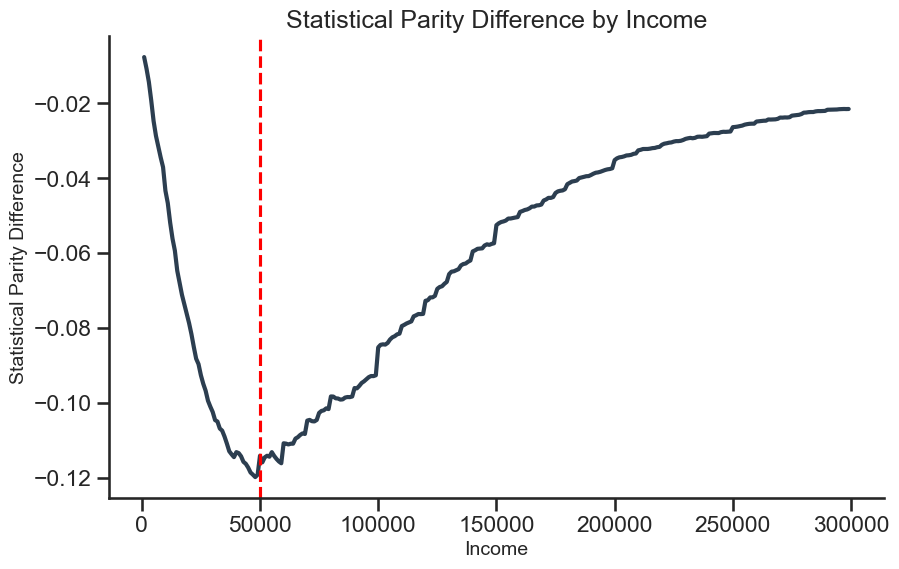

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc_file_defaults
import seaborn as sns

def plot_statistical_parity_difference(df):
    """
    This function takes a dataframe as input and plots the statistical parity difference
    for gender (males and females) for each value of the income.

    Args:
    - df (pandas.DataFrame): input dataframe with columns 'gender', 'income' and 'target'

    Returns:
    - None
    """
    # Calculate the total number of males and females in the dataset
    total_males = df[df['SEX'] == 'Male'].shape[0]
    total_females = df[df['SEX'] == 'Female'].shape[0]

    
    
    # Calculate the statistical parity difference for each income level
    # SPD = P(Y=1 ∣ A=minority)−P(Y=1 ∣ A=majority)
    income_levels = range(1000, 300000, 1000)
    spd_list = []
    
    for income_level in income_levels:
        
        income_df = df.copy()
        income_df['TARGET'] = income_df['PINCP'] > income_level
        
        # Calculate the number of males and females who received a positive target value
        males_positive = income_df[(income_df['SEX'] == 'Male') & (income_df['TARGET'] == True)].shape[0]
        females_positive = income_df[(income_df['SEX'] == 'Female') & (income_df['TARGET'] == True)].shape[0]
        
        spd = (females_positive/total_females) - (males_positive/total_males)
            
        spd_list.append(spd)
        
    # Set the style and context of the plot
    sns.set_style('ticks')
    sns.set_context('talk')
    
    # Create the plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=income_levels, y=spd_list, color='#2c3e50', linewidth=3)
    
    # Set the x and y labels and add a title
    plt.xlabel('Income', fontsize=14)
    plt.ylabel('Statistical Parity Difference', fontsize=14)
    plt.title('Statistical Parity Difference by Income', fontsize=18)
    
    # Add a vertical line at 50,000
    plt.axvline(x=50000, color='red', linestyle='--')
    
    # Remove the top and right spines of the plot
    sns.despine()
    
    plt.show()
    rc_file_defaults()

plot_statistical_parity_difference(df_cleaned)

### 3.4 Statistical tests

In [12]:
df_cleaned

RT       SERIALNO                            DIVISION   
0       Person Record  2018GQ0000012  Middle Atlantic (Northeast region)  \
1       Person Record  2018GQ0000040  Middle Atlantic (Northeast region)   
2       Person Record  2018GQ0000103  Middle Atlantic (Northeast region)   
3       Person Record  2018GQ0000105  Middle Atlantic (Northeast region)   
4       Person Record  2018GQ0000123  Middle Atlantic (Northeast region)   
...               ...            ...                                 ...   
103016  Person Record  2018HU1400910  Middle Atlantic (Northeast region)   
103017  Person Record  2018HU1400922  Middle Atlantic (Northeast region)   
103018  Person Record  2018HU1400922  Middle Atlantic (Northeast region)   
103019  Person Record  2018HU1400927  Middle Atlantic (Northeast region)   
103020  Person Record  2018HU1400927  Middle Atlantic (Northeast region)   

        SPORDER  PUMA     REGION           ST                  ADJINC  PWGTP   
0             1  3802  Northeast  New York/NY  2018 factor (1.013097)    145  \
1             1  2702  Northeast  New York/NY  2018 factor (1.013097)     43   
2             1  1400  Northeast  New York/NY  2018 factor (1.013097)     83   
3             1  3304  Northeast  New York/NY  2018 factor (1.013097)     48   
4             1  3107  Northeast  New York/NY  2018 factor (1.013097)     76   
...         ...   ...        ...          ...                     ...    ...   
103016        3  3708  Northeast  New York/NY  2018 factor (1.013097)    189   
103017        1  4006  Northeast  New York/NY  2018 factor (1.013097)    113   
103018        2  4006  Northeast  New York/NY  2018 factor (1.013097)    129   
103019        1  3903  Northeast  New York/NY  2018 factor (1.013097)     93   
103020        2  3903  Northeast  New York/NY  2018 factor (1.013097)     69   

        AGEP  ... PWGTP72  PWGTP73 PWGTP74 PWGTP75 PWGTP76 PWGTP77 PWGTP78   
0         26  ...     146       21      24     266     263      21     146  \
1         21  ...      42       43       7      40       6      43      40   
2         19  ...      12       80     154      12      80      12      83   
3         22  ...      48       48      48      48       9       6      49   
4         19  ...      74       76     139      74     138      75      74   
...      ...  ...     ...      ...     ...     ...     ...     ...     ...   
103016    65  ...     204      205      57     294     335     318     316   
103017    36  ...      36       33      31     119      96     106     104   
103018    38  ...      51       37      35     144     107     114     122   
103019    27  ...      92       83      88      26      35      28     103   
103020    56  ...      59       60      70      21      23      20      69   

       PWGTP79 PWGTP80 TARGET  
0          265     144  False  
1           42       6  False  
2          152     154  False  
3           49      47  False  
4           74      11  False  
...        ...     ...    ...  
103016      65     204  False  
103017     114      34   True  
103018     116      36   True  
103019     139     183  False  
103020     100     124  False  

[103021 rows x 287 columns]

#### 3.4.1 Mann-Whitney U test

In [13]:
get_mannwhitneyu(df_cleaned, class_name = 'SEX', alpha = 0.05)

({'WKHP': 0.0,
  'PERNP': 0.0,
  'PINCP': 0.0,
  'WAGP': 7.528342219695027e-264,
  'INTP': 8.801466729676097e-66,
  'SEMP': 1.1819097658580565e-50,
  'JWMNP': 2.2761031619951974e-36,
  'MARHYP': 2.7321614011173154e-30,
  'POVPIP': 2.4873922085503447e-29,
  'PAP': 9.800042169584866e-16,
  'RETP': 1.1409786169406798e-13,
  'OIP': 9.696693751761083e-12,
  'JWRIP': 4.8368592174402166e-06,
  'AGEP': 1.1898275048819797e-05,
  'PWGTP46': 0.0005036745307770862,
  'PWGTP': 0.0005461841384666714,
  'PWGTP28': 0.0005626139692938695,
  'CITWP': 0.0006622932371027676,
  'SSP': 0.0007684941788710959,
  'PWGTP74': 0.0012113587827810852,
  'PWGTP9': 0.0013446949464122864,
  'PWGTP53': 0.0020350623821569114,
  'PWGTP75': 0.0021397118639185438,
  'PWGTP66': 0.002176846912882145,
  'PWGTP5': 0.0022626473930358617,
  'PWGTP45': 0.0032774878050608612,
  'PWGTP23': 0.0033247900084984678,
  'PWGTP14': 0.003585293192554266,
  'PWGTP13': 0.00365484380981756,
  'PWGTP79': 0.0038236849262602455,
  'PWGTP10': 0.0

#### 3.4.2 Chi Square test

In [14]:
pd.crosstab(df_cleaned['SEX'], df_cleaned['SFR'])

SFR     Child in a father-child subfamily   
SEX                                         
Female                                  4  \
Male                                    1   

SFR     Child in a married-couple subfamily   
SEX                                           
Female                                    2  \
Male                                      2   

SFR     Child in a mother-child subfamily  Husband/wife no children   
SEX                                                                   
Female                                  9                       314  \
Male                                    6                       360   

SFR     Husband/wife with children  Parent in a one-parent subfamily  
SEX                                                                   
Female                         217                               889  
Male                           286                               219

In [15]:
get_fisher_exact(df_cleaned, class_name = 'SEX', alpha = 0.05)

  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=16440 is too small for this problem,
  (pastp=25.1014, ipn_0:=ipoin[itp=271]=126, stp[ipn_0]=29.8637).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=4800 is too small for this problem,
  (pastp=9.91146, ipn_0:=ipoin[itp=100]=4719, stp[ipn_0]=6.04025).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 7(location). LDSTP=12780 is too small for this problem,
  (pastp=23.1094, ipn_0:=ipoin[itp=31]=4981, stp[ipn_0]=1.09861).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=11130 is too small for this problem,
  (pastp=14.0748, ipn_0:=ipoin[itp=1]=1777, stp[ipn_0]=3.98898).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 7(location). LDSTP=12690 is too small for this problem,
  (pastp=8.31777, ipn_0:=ipoin[itp=213]=12456, stp[ipn_0]=4.27667).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 7(location). LDSTP=14310 is too small for this problem,
  (pastp=7.97797, ipn_0:=ipoin[itp=321]=6564, stp[ipn_0]=3.68888).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 6.  LDKEY=-1 is too small for this problem,
  (ii := key2[itp=2] = 1093665649, ldstp=-30)
Try increasing the size of the workspace and possibly 'mult'



  FEXACT error 6 (f5xact).  LDKEY=30 is too small for this problem: kval=2083269303.
Try increasing the size of the workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=18240 is too small for this problem,
  (pastp=309.474, ipn_0:=ipoin[itp=586]=18237, stp[ipn_0]=310.802).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=17940 is too small for this problem,
  (pastp=33.9519, ipn_0:=ipoin[itp=195]=406, stp[ipn_0]=16.7158).
Increase workspace or consider using 'simulate.p.value=TRUE'



({'SEX': 0.0,
  'FFERP': 0.0,
  'MLPFG': 4.88996276778402e-06,
  'RELP': 0.0004997501249375312,
  'SCHG': 0.0004997501249375312,
  'ANC1P': 0.0004997501249375312,
  'ANC2P': 0.0004997501249375312,
  'FOD1P': 0.0004997501249375312,
  'FOD2P': 0.0004997501249375312,
  'INDP': 0.0004997501249375312,
  'JWAP': 0.0004997501249375312,
  'LANP': 0.0004997501249375312,
  'NAICSP': 0.0004997501249375312,
  'OCCP': 0.0004997501249375312,
  'POBP': 0.0004997501249375312,
  'POWPUMA': 0.0004997501249375312,
  'POWSP': 0.0004997501249375312,
  'RAC2P': 0.0004997501249375312,
  'RAC3P': 0.0004997501249375312,
  'SFR': 0.0004997501249375312,
  'SOCP': 0.0004997501249375312,
  'VPS': 0.0004997501249375312,
  'RACNUM': 0.0009995002498750624,
  'MLPH': 0.012252393223409219,
  'FDRATP': 0.02158173922318253},
 {'MIGSP': 0.1904047976011994,
  'FHINS5C': 0.3223596347921454,
  'SFN': 0.5599756217341135,
  'MIGPUMA': 0.5762118940529735,
  'MLPI': 0.6110596604121189,
  'MLPJ': 0.6916317880015697,
  'SERIALNO':

In [16]:
get_chi2(df_cleaned, class_name = 'SEX', alpha = 0.05, strict = True)

({'COW': 0.0,
  'MIL': 0.0,
  'JWDP': 0.0,
  'SCHL': 1.0281537274613225e-285,
  'MAR': 4.300202394279713e-267,
  'MSP': 7.71930142247821e-266,
  'SCIENGP': 6.02229929699263e-160,
  'HINS6': 1.626161188589624e-140,
  'SCIENGRLP': 8.334589355027766e-129,
  'JWTR': 2.7306348247711353e-107,
  'HICOV': 1.947450232985797e-79,
  'WKW': 2.2693572820504287e-60,
  'RACBLK': 4.415740568312414e-55,
  'FDRATXP': 2.054056395246695e-49,
  'RAC1P': 1.3653281132045671e-48,
  'ESR': 1.7503030862484526e-46,
  'FMILPP': 3.833412026823468e-45,
  'SCH': 1.0019557833833926e-43,
  'DEAR': 8.610447253772275e-30,
  'GCL': 5.752270104457673e-26,
  'HISP': 4.094216542065297e-23,
  'NWLA': 6.859516022131609e-22,
  'NWAB': 9.39333651433007e-22,
  'CIT': 1.0008134078412635e-21,
  'HINS5': 1.0345070733389857e-18,
  'MLPE': 5.620800641938691e-18,
  'RACWHT': 5.4123940872532366e-17,
  'HINS4': 1.1238779445240352e-16,
  'ANC': 5.564595024237241e-16,
  'FMARHMP': 1.637665064846602e-15,
  'PUMA': 2.898352380352626e-13,
  

In [17]:
apply_categorical_tests(df_cleaned, class_name = 'SEX', alpha = 0.05)

  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=16440 is too small for this problem,
  (pastp=25.1014, ipn_0:=ipoin[itp=271]=126, stp[ipn_0]=29.8637).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=4800 is too small for this problem,
  (pastp=9.91146, ipn_0:=ipoin[itp=100]=4719, stp[ipn_0]=6.04025).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 7(location). LDSTP=12780 is too small for this problem,
  (pastp=23.1094, ipn_0:=ipoin[itp=31]=4981, stp[ipn_0]=1.09861).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=11130 is too small for this problem,
  (pastp=14.0748, ipn_0:=ipoin[itp=1]=1777, stp[ipn_0]=3.98898).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 7(location). LDSTP=12690 is too small for this problem,
  (pastp=8.31777, ipn_0:=ipoin[itp=213]=12456, stp[ipn_0]=4.27667).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 7(location). LDSTP=14310 is too small for this problem,
  (pastp=7.97797, ipn_0:=ipoin[itp=321]=6564, stp[ipn_0]=3.68888).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 6.  LDKEY=-1 is too small for this problem,
  (ii := key2[itp=2] = 0, ldstp=-30)
Try increasing the size of the workspace and possibly 'mult'



  FEXACT error 6 (f5xact).  LDKEY=30 is too small for this problem: kval=2083269303.
Try increasing the size of the workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=18240 is too small for this problem,
  (pastp=309.474, ipn_0:=ipoin[itp=586]=18237, stp[ipn_0]=310.802).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=17940 is too small for this problem,
  (pastp=33.9519, ipn_0:=ipoin[itp=195]=406, stp[ipn_0]=16.7158).
Increase workspace or consider using 'simulate.p.value=TRUE'



({'SEX': 0.0,
  'FFERP': 0.0,
  'COW': 0.0,
  'MIL': 0.0,
  'JWDP': 0.0,
  'SCHL': 1.0281537274613225e-285,
  'MAR': 4.300202394279713e-267,
  'MSP': 7.71930142247821e-266,
  'SCIENGP': 6.02229929699263e-160,
  'HINS6': 1.626161188589624e-140,
  'SCIENGRLP': 8.334589355027766e-129,
  'JWTR': 2.7306348247711353e-107,
  'HICOV': 1.947450232985797e-79,
  'WKW': 2.2693572820504287e-60,
  'RACBLK': 4.415740568312414e-55,
  'FDRATXP': 2.054056395246695e-49,
  'RAC1P': 1.3653281132045671e-48,
  'ESR': 1.7503030862484526e-46,
  'FMILPP': 3.833412026823468e-45,
  'SCH': 1.0019557833833926e-43,
  'DEAR': 8.610447253772275e-30,
  'GCL': 5.752270104457673e-26,
  'HISP': 4.094216542065297e-23,
  'NWLA': 6.859516022131609e-22,
  'NWAB': 9.39333651433007e-22,
  'CIT': 1.0008134078412635e-21,
  'HINS5': 1.0345070733389857e-18,
  'MLPE': 5.620800641938691e-18,
  'RACWHT': 5.4123940872532366e-17,
  'HINS4': 1.1238779445240352e-16,
  'ANC': 5.564595024237241e-16,
  'FMARHMP': 1.637665064846602e-15,
  'PU

Class related attributes:

In [18]:
apply_categorical_tests(df_cleaned, class_name = 'TARGET', alpha = 0.05)

  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=16440 is too small for this problem,
  (pastp=6.04025, ipn_0:=ipoin[itp=204]=31, stp[ipn_0]=16.7098).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=4800 is too small for this problem,
  (pastp=9.54681, ipn_0:=ipoin[itp=134]=4776, stp[ipn_0]=3.55535).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 7(location). LDSTP=12780 is too small for this problem,
  (pastp=3.29584, ipn_0:=ipoin[itp=151]=8560, stp[ipn_0]=3.46574).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=11130 is too small for this problem,
  (pastp=14.7679, ipn_0:=ipoin[itp=95]=11024, stp[ipn_0]=7.02554).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 7(location). LDSTP=12690 is too small for this problem,
  (pastp=11.7835, ipn_0:=ipoin[itp=288]=11461, stp[ipn_0]=1.09861).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 7(location). LDSTP=14310 is too small for this problem,
  (pastp=14.8325, ipn_0:=ipoin[itp=147]=14199, stp[ipn_0]=2.99573).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 6.  LDKEY=-1 is too small for this problem,
  (ii := key2[itp=2] = 1093665649, ldstp=-30)
Try increasing the size of the workspace and possibly 'mult'



  FEXACT error 6 (f5xact).  LDKEY=30 is too small for this problem: kval=2060364954.
Try increasing the size of the workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=18240 is too small for this problem,
  (pastp=320.402, ipn_0:=ipoin[itp=263]=106, stp[ipn_0]=317.119).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=17940 is too small for this problem,
  (pastp=33.1797, ipn_0:=ipoin[itp=387]=897, stp[ipn_0]=7.77486).
Increase workspace or consider using 'simulate.p.value=TRUE'



({'PUMA': 0.0,
  'COW': 0.0,
  'ENG': 0.0,
  'HINS1': 0.0,
  'HINS4': 0.0,
  'JWTR': 0.0,
  'MAR': 0.0,
  'NWAB': 0.0,
  'NWLA': 0.0,
  'NWLK': 0.0,
  'SCH': 0.0,
  'WKW': 0.0,
  'WRK': 0.0,
  'ESR': 0.0,
  'HICOV': 0.0,
  'MSP': 0.0,
  'PRIVCOV': 0.0,
  'PUBCOV': 0.0,
  'HISP': 3.207608849359444e-308,
  'SEX': 1.6577399431721754e-302,
  'RACWHT': 4.148492968250435e-249,
  'FPERNP': 1.0871633447097701e-242,
  'NWAV': 8.443025680134774e-233,
  'FWAGP': 1.3095720840241805e-219,
  'WAOB': 2.7080093149562415e-217,
  'RACSOR': 4.4352645832431095e-214,
  'DECADE': 4.3716495352312685e-206,
  'FFODP': 6.717232452841207e-206,
  'FPINCP': 1.8801956505928018e-205,
  'FMARP': 1.071074087941577e-195,
  'CIT': 3.4166505860875497e-195,
  'FHINS1P': 9.012037698756705e-178,
  'FWKWP': 1.6180147961796948e-177,
  'RC': 6.748151920975666e-177,
  'FWKHP': 5.535182552653035e-172,
  'OC': 2.5125802868196823e-166,
  'FINDP': 6.167009359361576e-160,
  'FOCCP': 3.6831777190263786e-159,
  'FCOWP': 2.229080448282

In [19]:
get_mannwhitneyu(df_cleaned, class_name = 'TARGET', alpha = 0.05)

({'SPORDER': 0.0,
  'AGEP': 0.0,
  'INTP': 0.0,
  'JWMNP': 0.0,
  'WAGP': 0.0,
  'WKHP': 0.0,
  'PERNP': 0.0,
  'PINCP': 0.0,
  'POVPIP': 0.0,
  'YOEP': 2.7629982782739786e-221,
  'RETP': 6.2876751108940426e-217,
  'CITWP': 6.884766583149035e-87,
  'PAP': 4.674183942034575e-78,
  'JWRIP': 2.5986833596309047e-53,
  'SSIP': 3.004755619014018e-26,
  'SSP': 2.8427809633226562e-24,
  'MARHYP': 9.422211585078232e-09,
  'PWGTP12': 0.0007792543159683742,
  'PWGTP60': 0.0021474548070091583,
  'PWGTP64': 0.002334334441928073,
  'PWGTP68': 0.002998029041944358,
  'PWGTP77': 0.003607026509307494,
  'PWGTP30': 0.0037694009477881505,
  'PWGTP27': 0.005464242519881203,
  'PWGTP2': 0.007641864735977163,
  'PWGTP53': 0.008061525177367468,
  'PWGTP76': 0.01061791036531091,
  'PWGTP39': 0.011764887512174428,
  'PWGTP34': 0.012085835776153353,
  'PWGTP33': 0.012781430282898326,
  'PWGTP1': 0.013836696420707329,
  'PWGTP21': 0.014711959131592157,
  'PWGTP41': 0.014722262365801823,
  'PWGTP40': 0.0165783570

#### 3.4.3 Plot dictionaries

In [20]:
dep, ind = get_mannwhitneyu(df_cleaned, class_name = 'SEX', alpha = 0.01)
mannU = {**dep, **ind}
mannU = {k: v for k, v in mannU.items() if not math.isnan(v)}
mannU = {k: v for k, v in sorted(mannU.items(), key=lambda item: item[1], reverse=False)}

dep, ind = apply_categorical_tests(df_cleaned, class_name = 'SEX', alpha = 0.01)
chi2 = {**dep, **ind}
chi2 = {k: v for k, v in sorted(chi2.items(), key=lambda item: item[1], reverse=False)}

  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=16440 is too small for this problem,
  (pastp=25.1014, ipn_0:=ipoin[itp=271]=126, stp[ipn_0]=29.8637).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=4800 is too small for this problem,
  (pastp=9.91146, ipn_0:=ipoin[itp=100]=4719, stp[ipn_0]=6.04025).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 7(location). LDSTP=12780 is too small for this problem,
  (pastp=23.1094, ipn_0:=ipoin[itp=31]=4981, stp[ipn_0]=1.09861).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=11130 is too small for this problem,
  (pastp=14.0748, ipn_0:=ipoin[itp=1]=1777, stp[ipn_0]=3.98898).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 7(location). LDSTP=12690 is too small for this problem,
  (pastp=8.31777, ipn_0:=ipoin[itp=213]=12456, stp[ipn_0]=4.27667).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 7(location). LDSTP=14310 is too small for this problem,
  (pastp=7.97797, ipn_0:=ipoin[itp=321]=6564, stp[ipn_0]=3.68888).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 6.  LDKEY=-1 is too small for this problem,
  (ii := key2[itp=2] = 0, ldstp=-30)
Try increasing the size of the workspace and possibly 'mult'



  FEXACT error 6 (f5xact).  LDKEY=30 is too small for this problem: kval=2083269303.
Try increasing the size of the workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=18240 is too small for this problem,
  (pastp=309.474, ipn_0:=ipoin[itp=586]=18237, stp[ipn_0]=310.802).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=17940 is too small for this problem,
  (pastp=33.9519, ipn_0:=ipoin[itp=195]=406, stp[ipn_0]=16.7158).
Increase workspace or consider using 'simulate.p.value=TRUE'



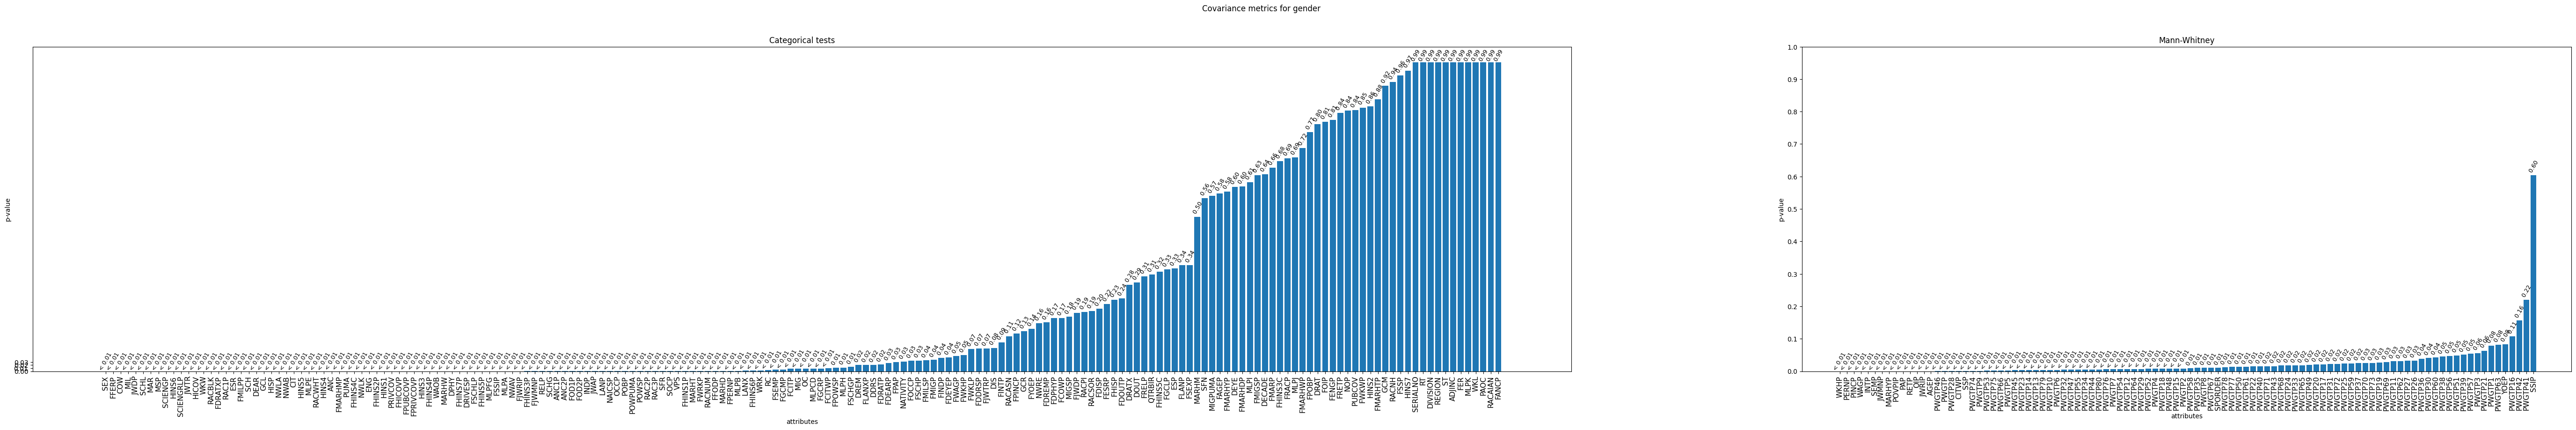

In [21]:
def plot_dictionaries(list_dict, title='chart plot', labels=[]):
    fig, axes = plt.subplots(1, len(list_dict), figsize=(70, 9), gridspec_kw={'width_ratios': [2, 1]})
    fig.suptitle(title)
    for i, ax in enumerate(axes):
        d = list_dict[i]
        x = range(len(d))
        y = list(d.values())
        ax.bar(x, y, align='center')
        ax.set_title(labels[i])
        if labels[i] == 'Chi-Square':
            ax.set_yticks(np.arange(0, 1.1, 0.1))
        elif labels[i] == 'Mann-Whitney':
            ax.set_yticks(np.arange(0, 1.1, 0.1))
        else:
            ax.set_yticks(np.arange(0, 0.04, 0.01))
        ax.set_xticks(x)
        ax.set_xticklabels(d.keys(), rotation=90, fontsize=11)
        for j, v in enumerate(y):
            if v == 1:
                ax.text(j, v, "0.99", ha='center', va='bottom', fontsize=9, rotation=60)
            elif v >= 0.01 and v != 1:
                ax.text(j, v, f" {v:.2f}", ha='center', va='bottom', fontsize=9, rotation=60)
            else:
                ax.text(j, v, "< 0.01", ha='center', va='bottom', fontsize=9, rotation=60)
                
    for ax in axes.flat:
        ax.set(xlabel='attributes', ylabel='p-value')

plot_dictionaries([chi2, mannU], labels=['Categorical tests', 'Mann-Whitney'], title = 'Covariance metrics for gender')

Top 10 features related with gender:

- MIL: Military Service
- SEX: Gender
- WKHP: Usual hours worked per week past 12 months
- INDP: Industry recode (e.g. Coal Mining, Animal food, etc.)
- OCCP: Occupation recode (e.g. Farmer, human Resources, etc.)
- PERNP: Total person earnings
- PINCP: total person's income
- FFERP: Gave birth to child within the past 12 months
- WAGP: Wages or salary income past 12 months
- SCHL: Educational attainment


Improvements:
- Choose appropiate statistical tests (check if normal distribution with another test and then use appropiate, check assumptions). Kind of automatizise the process

**Other state comparision:**

In [ ]:
data_source = ACSDataSource(survey_year=YEAR, horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=STATES_TO_COMPARE, download=True)
feature_codes = list(acs_data.columns)
ACSIncome = BasicProblem(
    features=[feature_codes],
    target='PINCP',
    target_transform=lambda x: x > 50000,    
    group='SEX',
    preprocess=adult_filter,
    postprocess=lambda x: x,
)
features, label, group = ACSIncome.df_to_numpy(acs_data)
df_state2 = pd.concat([pd.DataFrame(features), pd.DataFrame(label)], axis=1)
df_state2.columns = feature_codes + ['TARGET']
definition_df = data_source.get_definitions(download=True)
df_state2_cleaned = clean_df(df_state2, definition_df)

dep, ind = get_mannwhitneyu(df_state2_cleaned, class_name = 'SEX', alpha = 0.01)
mannU = {**dep, **ind}
mannU = {k: v for k, v in mannU.items() if not math.isnan(v)}
mannU = {k: v for k, v in sorted(mannU.items(), key=lambda item: item[1], reverse=False)}

dep, ind = apply_categorical_tests(df_state2_cleaned, class_name = 'SEX', alpha = 0.01)
chi2 = {**dep, **ind}
chi2 = {k: v for k, v in sorted(chi2.items(), key=lambda item: item[1], reverse=False)}

plot_dictionaries([chi2, mannU], labels=['Chi-Square', 'Mann-Whitney'], title = 'Covariance metrics for gender')

Top features related with gender in NY:

- COW: Class of worker
- MIL: Military Service
- SEX: Gender
- FOD1P: Recoded field of degree
- INDP: Industry recode (e.g. Coal Mining, Animal food, etc.)
- JWAP: Time of arrival at work
- JWDP: Time of departure for work 
- NAICSP: North American Industry Classification System
- OCCP: Occupation recode (e.g. Farmer, human Resources, etc.)
- SOCP: Standard Occupational Classification (SOC) codes
- FFERP: Gave birth to child within the past 12 months
- WKHP: Usual hours worked per week past 12 months
- PERNP: Total person earnings
- PINCP: Total person's income

Top features related with gender in TX:
- COW: Class of worker
- **MAR: Marital status**
- MIL: Military Service
- SEX: Gender
- FOD1P: Recoded field of degree
- INDP: Industry recode (e.g. Coal Mining, Animal food, etc.)
- JWAP: Time of arrival at work
- JWDP: Time of departure for work 
- **MSP: Married, spouse present/spouse absent**
- NAICSP: North American Industry Classification System
- OCCP: Occupation recode (e.g. Farmer, human Resources, etc.)
- SOCP: Standard Occupational Classification (SOC) codes
- FFERP: Gave birth to child within the past 12 months
- WAGP: Wages or salary income past 12 months
- WKHP: Usual hours worked per week past 12 months
- PERNP: Total person earnings
- PINCP: Total person's income
    


In [ ]:
dep_s1_mann, ind_s1_mann = get_mannwhitneyu(df_cleaned, class_name = 'SEX', alpha = 0.01)
dep_s1_chi2, ind_s1_chi2 = apply_categorical_tests(df_cleaned, class_name = 'SEX', alpha = 0.01)
dep_s1 = {**dep_s1_mann, **dep_s1_chi2}
ind_s1 = {**ind_s1_mann, **ind_s1_chi2}
dep_s2_mann, ind_s2_mann = get_mannwhitneyu(df_state2_cleaned, class_name = 'SEX', alpha = 0.01)
dep_s2_chi2, ind_s2_chi2 = apply_categorical_tests(df_state2_cleaned, class_name = 'SEX', alpha = 0.01)
dep_s2 = {**dep_s2_mann, **dep_s2_chi2}
ind_s2 = {**ind_s2_mann, **ind_s2_chi2}

In [ ]:
print(f'Attributes related with gender in {STATES} but not in {STATES_TO_COMPARE}:\n')
for x in dep_s1.keys():
    if x not in dep_s2.keys():
        print(f'{x} ({get_definition(definition_df, x)})')
        print(f'\t {STATES_TO_COMPARE} p-value: {ind_s2[x]}   {STATES} p-value: {dep_s1[x]}')

In [ ]:
print(f'Attributes related with gender in {STATES_TO_COMPARE} but not in {STATES}:\n')
for x in dep_s2.keys():
    if x not in dep_s1.keys():
        print(f'{x} ({get_definition(definition_df, x)})')
        print(f'\t {STATES} p-value: {ind_s1[x]}   {STATES_TO_COMPARE} p-value: {dep_s2[x]}')

In [ ]:
# # PUBCOV (Public health coverage recode)
# # 	 NY p-value: 0.8441769122585738   TX p-value: 0.00019850112767425782

# df_females_ny = df_cleaned[df_cleaned['SEX'] == 'Female']
# df_males_ny = df_cleaned[df_cleaned['SEX'] == 'Male']
# df_females_tx = df_texas_cleaned[df_texas_cleaned['SEX'] == 'Female']
# df_males_tx = df_texas_cleaned[df_texas_cleaned['SEX'] == 'Male']

# print('Public health coverage\n')
# print('\t\tWithout\t\tWith\t\t% With')
# print(f"Females NY\t {df_females_ny['PUBCOV'].value_counts()[0]}\t\t{df_females_ny['PUBCOV'].value_counts()[1]}\t\t{df_females_ny['PUBCOV'].value_counts()[1]/(df_females_ny['PUBCOV'].value_counts()[0]+df_females_ny['PUBCOV'].value_counts()[1])}")
# print(f"Males NY\t {df_males_ny['PUBCOV'].value_counts()[0]}\t\t{df_males_ny['PUBCOV'].value_counts()[1]}\t\t{df_males_ny['PUBCOV'].value_counts()[1]/(df_males_ny['PUBCOV'].value_counts()[0]+df_males_ny['PUBCOV'].value_counts()[1])}")

# print(f"Females TX\t {df_females_tx['PUBCOV'].value_counts()[0]}\t\t{df_females_tx['PUBCOV'].value_counts()[1]}\t\t{df_females_tx['PUBCOV'].value_counts()[1]/(df_females_tx['PUBCOV'].value_counts()[0]+df_females_tx['PUBCOV'].value_counts()[1])}")
# print(f"Males TX\t {df_males_tx['PUBCOV'].value_counts()[0]}\t\t{df_males_tx['PUBCOV'].value_counts()[1]}\t\t{df_males_tx['PUBCOV'].value_counts()[1]/(df_males_tx['PUBCOV'].value_counts()[0]+df_males_tx['PUBCOV'].value_counts()[1])}")

# compare_histogram(df_males_ny,df_females_ny, 'PUBCOV')
# compare_histogram(df_males_tx,df_females_tx, 'PUBCOV')

### 3.5 Nan Visualization

In [12]:
def calculate_nan_percentage_gender(df, gender_column = 'gender'):
    nan_columns = df.columns[df.isna().any()].tolist() + [gender_column]
    
    # dataframe with only the columns that have NaN values
    df = df[nan_columns]

    # Group the dataframe by gender
    gender_groups = df.groupby(gender_column)
    
    # Calculate the percentage of NaN values per column for each gender group
    nan_percentages = gender_groups.apply(lambda x: x.isna().mean() * 100)
    
    # Add difference
    nan_percentages.loc['Difference'] = abs(nan_percentages.diff().iloc[-1])
    
    # Print the result
    return nan_percentages

def clean_nan(df, percentage = 10, verbose = False, gender_column = 'gender'):
    # Calculate percentage of NaNs per column
    nan_percentages = df.isna().sum() / len(df) * 100
    
    # Print NaN percentages per column
    if verbose == True:
        print('NaN percentages per column:\n', nan_percentages[nan_percentages > 0])
    
    # Get column names where more than percentage% of values are NaN
    nan_columns = nan_percentages[nan_percentages > percentage].index
    if verbose == True:
        print('Removing:\n', nan_columns)
    
    # Remove columns with more than percentage% NaN values
    df = df.drop(nan_columns, axis=1)
    
    # Remove columns where nan% difference between males and females is greater than 5%
    gender_nan_perc = calculate_nan_percentage_gender(df, gender_column)
    nan_gender_columns = gender_nan_perc.loc[:, gender_nan_perc.iloc[2, :] > 5].columns
    df = df.drop(nan_gender_columns, axis=1)
    
    # Fill NaN values in numerical columns with median
    numerical_columns = df.select_dtypes(include=['number']).columns
    df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].median()) 
    
    # Replace NaN values in categorical columns with 'nan_category'
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns   
    df[categorical_columns] = df[categorical_columns].fillna('nan_category')
    
    return df

def process_data_census(df):

    df = df.copy()

    # Create gender column (1 female 0 male)
    if 'SEX' in df.columns:
        df.insert(len(df.columns)-1, 'gender', np.where(df['SEX'] == 'Female', 1, 0))
        df = df.drop('SEX', axis=1)
        
    if 'TARGET' in df.columns:
        df.insert(len(df.columns)-1, 'Class', np.where(df['TARGET'] == True, 1, 0))
        df = df.drop('TARGET', axis=1)
    
    # Remove attributes related with income 
    attributes_to_remove = ['PINCP', 'PERNP', 'WAGP', 'SEMP', 'RETP', 'INTP',
                            'SSP', 'SSIP', 'OIP', 'SERIALNO']
    df = df.drop(attributes_to_remove,axis=1, errors='ignore')
    
    # Remove Person Weight columns (columns that start with "PWGTP")
    df = df.filter(regex='^(?!PWGTP)')
    
    # Nan dealing
    df = clean_nan(df)
    
    # Encoding (factorize)
    cols_enc = list(df.select_dtypes([object]).columns)

    for col in cols_enc:
        df[col], _ = pd.factorize(df[col])

    return df


In [23]:
df2 = df_cleaned.copy()
gender_nan_perc = calculate_nan_percentage_gender(df2, 'SEX')
gender_nan_perc.loc[:, gender_nan_perc.iloc[2, :] > 5]

DRATX         FER       MLPA       MLPB      MLPCD       MLPE   
SEX                                                                             
Female      98.998879   35.922349  99.230966  99.230966  99.230966  99.230966  \
Male        92.086703  100.000000  93.457013  93.457013  93.457013  93.457013   
Difference   6.912176   64.077651   5.773953   5.773953   5.773953   5.773953   

                MLPFG       MLPH       MLPI       MLPJ       MLPK      FOD1P   
SEX                                                                            
Female      99.230966  99.230966  99.230966  99.230966  99.230966  55.197372  \
Male        93.457013  93.457013  93.457013  93.457013  93.457013  61.272950   
Difference   5.773953   5.773953   5.773953   5.773953   5.773953   6.075578   

                  PAOC    SCIENGP  SCIENGRLP        VPS  
SEX                                                      
Female        3.620951  55.197372  55.197372  99.230966  
Male        100.000000  61.272950  61.272950  93.457013  
Difference   96.379049   6.075578   6.075578   5.773953

In [24]:
process_data_census(df2)

RT  DIVISION  SPORDER  PUMA  REGION  ST  ADJINC  AGEP  CIT  COW  ...   
0        0         0        1     0       0   0       0    26    0    0  ...  \
1        0         0        1     1       0   0       0    21    1    1  ...   
2        0         0        1     2       0   0       0    19    1    1  ...   
3        0         0        1     3       0   0       0    22    0    1  ...   
4        0         0        1     4       0   0       0    19    1    0  ...   
...     ..       ...      ...   ...     ...  ..     ...   ...  ...  ...  ...   
103016   0         0        3    96       0   0       0    65    0    1  ...   
103017   0         0        1    99       0   0       0    36    1    1  ...   
103018   0         0        2    99       0   0       0    38    1    1  ...   
103019   0         0        1    79       0   0       0    27    1    1  ...   
103020   0         0        2    79       0   0       0    56    2    1  ...   

        FSSIP  FSSP  FWAGP  FWKHP  FWKLP  FWKWP  FWRKP  FYOEP  gender  Class  
0           0     0      0      0      0      0      0      0       1      0  
1           1     1      1      1      1      1      0      0       0      0  
2           1     1      0      1      1      1      0      0       1      0  
3           1     1      1      1      1      1      0      0       1      0  
4           1     1      1      1      1      1      0      0       0      0  
...       ...   ...    ...    ...    ...    ...    ...    ...     ...    ...  
103016      1     1      1      1      1      1      0      0       1      0  
103017      1     1      1      1      1      1      0      0       1      1  
103018      1     1      1      1      1      1      0      0       0      1  
103019      1     1      1      1      1      1      0      0       0      0  
103020      0     0      1      0      1      0      0      0       0      0  

[103021 rows x 146 columns]

In [20]:
df['TARGET'].value_counts()
60294 / (60294 + 42727)

0.5852593160617738

### 3.6 Key variables to find gender

Experiment for finding the best explainable model for gender to explain relation with other attributes.

In [13]:
dependent_attributes, independent_attributes = apply_categorical_tests(df_cleaned, class_name = 'SEX', alpha = 0.01)
diff_dis_attributes, same_dis_attributes = get_mannwhitneyu(df_cleaned, class_name = 'SEX', alpha = 0.01)

dependent_attributes = {**dependent_attributes, **diff_dis_attributes}

attributes = [k for k,v in dependent_attributes.items()]
print(len(attributes))
X_train, X_test, y_train, y_test = split_data(process_data_census(df_cleaned[attributes]), 
                                              test_size = 0.20, y_name = 'gender', get_test = True)

  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=16440 is too small for this problem,
  (pastp=25.1014, ipn_0:=ipoin[itp=271]=126, stp[ipn_0]=29.8637).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=4800 is too small for this problem,
  (pastp=9.91146, ipn_0:=ipoin[itp=100]=4719, stp[ipn_0]=6.04025).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 7(location). LDSTP=12780 is too small for this problem,
  (pastp=23.1094, ipn_0:=ipoin[itp=31]=4981, stp[ipn_0]=1.09861).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=11130 is too small for this problem,
  (pastp=14.0748, ipn_0:=ipoin[itp=1]=1777, stp[ipn_0]=3.98898).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 7(location). LDSTP=12690 is too small for this problem,
  (pastp=8.31777, ipn_0:=ipoin[itp=213]=12456, stp[ipn_0]=4.27667).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 7(location). LDSTP=14310 is too small for this problem,
  (pastp=7.97797, ipn_0:=ipoin[itp=321]=6564, stp[ipn_0]=3.68888).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 6.  LDKEY=-1 is too small for this problem,
  (ii := key2[itp=2] = 1093665649, ldstp=-30)
Try increasing the size of the workspace and possibly 'mult'



  FEXACT error 6 (f5xact).  LDKEY=30 is too small for this problem: kval=2083269303.
Try increasing the size of the workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=18240 is too small for this problem,
  (pastp=309.474, ipn_0:=ipoin[itp=586]=18237, stp[ipn_0]=310.802).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=17940 is too small for this problem,
  (pastp=33.9519, ipn_0:=ipoin[itp=195]=406, stp[ipn_0]=16.7158).
Increase workspace or consider using 'simulate.p.value=TRUE'



147


In [14]:
cc = RandomUnderSampler(sampling_strategy=1.0,random_state=2)
X_res, y_res = cc.fit_resample(X_train, y_train)

clf = XGBClassifier()
clf = clf.fit(X_res, y_res)
y_pred = test_model(clf, X_test)

print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')

Accuracy: 0.7818490657607376


In [15]:
y_test.value_counts()[0] / (y_test.value_counts()[0] + y_test.value_counts()[1])

0.5064790099490415

In [ ]:
from xgboost import plot_tree

fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(clf, ax=ax)
plt.show()

In [ ]:
plot_importance(clf, max_num_features=10)

**Check which attributes are the most common selected:**

In [ ]:
# df2 = df_cleaned.copy()

# dependent_attributes, independent_attributes = get_chi2(df_cleaned, class_name = 'SEX', alpha = 0.01)
# diff_dis_attributes, same_dis_attributes = get_mannwhitneyu(df_cleaned, class_name = 'SEX', alpha = 0.01)

# dependent_attributes = {**dependent_attributes, **diff_dis_attributes}

# attributes = [k for k,v in dependent_attributes.items()]
# df2 = process_data_census(df2[attributes])

# ba_dict = {}
# for i in range(100):
#     print(i)
#     best_clf, best_attributes, best_acc = search_best_attributes(df2, class_name = 'gender', metric = 'f1')
    
#     for a in best_attributes:
#         if a in ba_dict:
#             ba_dict[a] += 1
#         else:
#             ba_dict[a] = 1
            
# {k: v for k, v in sorted(ba_dict.items(), key=lambda item: item[1], reverse=True)}

### 3.7 Key variables to find gender after removing dependent variables

Experiment for seeing the accuracy difference for guessing gender when correlated attributes are delated.

In [16]:
dependent_attributes, independent_attributes = apply_categorical_tests(df_cleaned, class_name = 'SEX', alpha = 0.01)
diff_dis_attributes, same_dis_attributes = get_mannwhitneyu(df_cleaned, class_name = 'SEX', alpha = 0.01)

independent_attributes = {**independent_attributes, **same_dis_attributes}

attributes = [k for k,v in independent_attributes.items()] + ['SEX']
print(len(attributes))
X_train, X_test, y_train, y_test = split_data(process_data_census(df_cleaned[attributes]), 
                                              test_size = 0.20, y_name = 'gender', get_test = True)

  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=16440 is too small for this problem,
  (pastp=25.1014, ipn_0:=ipoin[itp=271]=126, stp[ipn_0]=29.8637).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=4800 is too small for this problem,
  (pastp=9.91146, ipn_0:=ipoin[itp=100]=4719, stp[ipn_0]=6.04025).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 7(location). LDSTP=12780 is too small for this problem,
  (pastp=23.1094, ipn_0:=ipoin[itp=31]=4981, stp[ipn_0]=1.09861).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=11130 is too small for this problem,
  (pastp=14.0748, ipn_0:=ipoin[itp=1]=1777, stp[ipn_0]=3.98898).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 7(location). LDSTP=12690 is too small for this problem,
  (pastp=8.31777, ipn_0:=ipoin[itp=213]=12456, stp[ipn_0]=4.27667).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 7(location). LDSTP=14310 is too small for this problem,
  (pastp=7.97797, ipn_0:=ipoin[itp=321]=6564, stp[ipn_0]=3.68888).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 6.  LDKEY=-1 is too small for this problem,
  (ii := key2[itp=2] = 0, ldstp=-30)
Try increasing the size of the workspace and possibly 'mult'



  FEXACT error 6 (f5xact).  LDKEY=30 is too small for this problem: kval=2083269303.
Try increasing the size of the workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=18240 is too small for this problem,
  (pastp=309.474, ipn_0:=ipoin[itp=586]=18237, stp[ipn_0]=310.802).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=17940 is too small for this problem,
  (pastp=33.9519, ipn_0:=ipoin[itp=195]=406, stp[ipn_0]=16.7158).
Increase workspace or consider using 'simulate.p.value=TRUE'



140


In [17]:
cc = RandomUnderSampler(sampling_strategy=1.0,random_state=2)
X_res, y_res = cc.fit_resample(X_train, y_train)

clf = XGBClassifier()
clf = clf.fit(X_res, y_res)
y_pred = test_model(clf, X_test)

print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')

Accuracy: 0.5332200922106285


In [ ]:
from xgboost import plot_tree

fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(clf, ax=ax)
plt.show()

In [ ]:
plot_importance(clf, max_num_features=10)

## 4. Models experiments

In [25]:
# if os.path.isfile('df_processed.csv') == True:
#     print('Reading df_processed...')
#     df_processed = pd.read_csv('df_processed.csv')
# else:
#     df_processed = process_data_census(df_cleaned)
#     df_processed.to_csv('df_processed.csv')

df_processed = process_data_census(df_cleaned)
df_processed

RT  DIVISION  SPORDER  PUMA  REGION  ST  ADJINC  AGEP  CIT  COW  ...   
0        0         0        1     0       0   0       0    26    0    0  ...  \
1        0         0        1     1       0   0       0    21    1    1  ...   
2        0         0        1     2       0   0       0    19    1    1  ...   
3        0         0        1     3       0   0       0    22    0    1  ...   
4        0         0        1     4       0   0       0    19    1    0  ...   
...     ..       ...      ...   ...     ...  ..     ...   ...  ...  ...  ...   
103016   0         0        3    96       0   0       0    65    0    1  ...   
103017   0         0        1    99       0   0       0    36    1    1  ...   
103018   0         0        2    99       0   0       0    38    1    1  ...   
103019   0         0        1    79       0   0       0    27    1    1  ...   
103020   0         0        2    79       0   0       0    56    2    1  ...   

        FSSIP  FSSP  FWAGP  FWKHP  FWKLP  FWKWP  FWRKP  FYOEP  gender  Class  
0           0     0      0      0      0      0      0      0       1      0  
1           1     1      1      1      1      1      0      0       0      0  
2           1     1      0      1      1      1      0      0       1      0  
3           1     1      1      1      1      1      0      0       1      0  
4           1     1      1      1      1      1      0      0       0      0  
...       ...   ...    ...    ...    ...    ...    ...    ...     ...    ...  
103016      1     1      1      1      1      1      0      0       1      0  
103017      1     1      1      1      1      1      0      0       1      1  
103018      1     1      1      1      1      1      0      0       0      1  
103019      1     1      1      1      1      1      0      0       0      0  
103020      0     0      1      0      1      0      0      0       0      0  

[103021 rows x 146 columns]

In [26]:
X_train, X_test, y_train, y_test = split_data(df_processed, test_size = 0.25, y_name = 'Class', get_test = True)

cc = RandomUnderSampler(sampling_strategy=1.0,random_state=2)
X_res, y_res = cc.fit_resample(X_train, y_train)
X_res

RT  DIVISION  SPORDER  PUMA  REGION  ST  ADJINC  AGEP  CIT  COW  ...   
0       0         0        1    87       0   0       0    49    0    1  ...  \
1       0         0        1    28       0   0       0    26    1    1  ...   
2       0         0        2     8       0   0       0    33    4    1  ...   
3       0         0        5    31       0   0       0    57    2    1  ...   
4       0         0        4    14       0   0       0    23    1    1  ...   
...    ..       ...      ...   ...     ...  ..     ...   ...  ...  ...  ...   
64085   0         0        1    73       0   0       0    61    1    1  ...   
64086   0         0        1    98       0   0       0    60    1    5  ...   
64087   0         0        1    31       0   0       0    57    2    1  ...   
64088   0         0        2    42       0   0       0    58    1    1  ...   
64089   0         0        1    50       0   0       0    64    1    1  ...   

       FSEXP  FSSIP  FSSP  FWAGP  FWKHP  FWKLP  FWKWP  FWRKP  FYOEP  gender  
0          0      1     1      1      1      1      1      0      0       0  
1          0      1     1      1      1      1      1      0      0       1  
2          0      1     1      1      1      1      0      0      1       0  
3          0      1     1      1      1      1      1      0      0       1  
4          0      1     1      1      1      1      1      0      0       1  
...      ...    ...   ...    ...    ...    ...    ...    ...    ...     ...  
64085      0      1     1      1      1      1      1      0      0       0  
64086      0      1     1      1      1      1      1      0      0       1  
64087      0      1     1      1      1      1      1      0      0       1  
64088      0      1     1      0      1      1      1      0      0       0  
64089      0      1     1      1      1      1      1      0      0       1  

[64090 rows x 145 columns]

In [ ]:
# X_res = process_data_census(X_res)
# X_test = process_data_census(X_test)
# y_res = y_res.replace({'Male':0, 'Female':1})
# y_test = y_test.replace({'Male':0, 'Female':1})

# columns = list(set(list(X_res.columns) + list(X_test.columns)))
# X_res = X_res[columns]
# X_test = X_test[columns]

### 4.1. Training

In [ ]:
X_res

#### 4.1.1. Training with all attributes

In [27]:
accuracies = []
auc_scores = []
f1_scores = []
f1_weighted_scores = []
results = []

for i in range(10):
    print(i)
    
    clf = XGBClassifier(seed=i)
    clf = clf.fit(X_res, y_res)
    y_pred = test_model(clf, X_test)
    
    accuracies.append(metrics.accuracy_score(y_test, y_pred))
    auc_scores.append(metrics.roc_auc_score(y_test, y_pred))
    f1_scores.append(metrics.f1_score(y_test,y_pred))
    f1_weighted_scores.append(metrics.f1_score(y_test, y_pred, average='weighted'))
    
    res_df = get_res_df(X_test, y_test, y_pred)
    results.append(apply_metrics.fair_metrics(res_df, favorable_class=1))

0
1
2
3
4
5
6
7
8
9


In [28]:
print('Accuracy: ',sum(accuracies)/len(accuracies),'±', np.std(accuracies))
print('AUC: ',sum(auc_scores)/len(auc_scores),'±', np.std(auc_scores))
print('F1: ',sum(f1_scores)/len(f1_scores),'±', np.std(f1_scores))
print('F1 Weighted: ',sum(f1_weighted_scores)/len(f1_weighted_scores),'±', np.std(f1_weighted_scores))

final_results_1 = {'Accuracy': (sum(accuracies)/len(accuracies),np.std(accuracies))}

for key in results[0].keys():
    print(f'{key}: {sum(r[key] for r in results) / len(results)} ± {np.std([r[key] for r in results])}')
    final_results_1[key] = (sum(r[key] for r in results) / len(results), np.std([r[key] for r in results]))

Accuracy:  0.8856577108246622 ± 1.1102230246251565e-16
AUC:  0.8877634798577285 ± 1.1102230246251565e-16
F1:  0.8671927846674181 ± 1.1102230246251565e-16
F1 Weighted:  0.8861681602609892 ± 1.1102230246251565e-16
statistical_parity_difference: -0.12707580343359207 ± 2.7755575615628914e-17
predictive_parity_difference: -0.02306830861806919 ± 0.0
false_positive_error_rate_balance: -0.0415636202927139 ± 6.938893903907228e-18
equal_opportunity_difference: -0.04694541746757597 ± 0.0
false_negative_rate_difference: 0.04694541746757599 ± 6.938893903907228e-18
equalized_odds: 0.04425451888014493 ± 0.0
overall_accuracy_equality: 0.0024814061916992314 ± 0.0


In [ ]:
from xgboost import plot_tree

fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(clf, ax=ax)
plt.show()

In [ ]:
plot_importance(clf, max_num_features=10)

#### 4.1.2. Training models with all attributes but gender

In [29]:
accuracies = []
auc_scores = []
f1_scores = []
f1_weighted_scores = []
results = []

for i in range(10):
    print(i)
    # X_train, X_test, y_train, y_test = split_data(df_preprocessed, test_size = 0.2)
    # clf = train_model(X_train, y_train)
    clf = XGBClassifier(seed=i)
    clf = clf.fit(X_res.loc[:, X_res.columns != 'gender'], y_res)
    y_pred = test_model(clf, X_test.loc[:, X_test.columns != 'gender'])
    
    accuracies.append(metrics.accuracy_score(y_test, y_pred))
    auc_scores.append(metrics.roc_auc_score(y_test, y_pred))
    f1_scores.append(metrics.f1_score(y_test,y_pred))
    f1_weighted_scores.append(metrics.f1_score(y_test, y_pred, average='weighted'))

    res_df = get_res_df(X_test, y_test, y_pred)
    results.append(apply_metrics.fair_metrics(res_df, favorable_class=1))

0
1
2
3
4
5
6
7
8
9


In [30]:
print('Accuracy: ',sum(accuracies)/len(accuracies),'±', np.std(accuracies))
print('AUC: ',sum(auc_scores)/len(auc_scores),'±', np.std(auc_scores))
print('F1: ',sum(f1_scores)/len(f1_scores),'±', np.std(f1_scores))
print('F1 Weighted: ',sum(f1_weighted_scores)/len(f1_weighted_scores),'±', np.std(f1_weighted_scores))

final_results_2 = {'Accuracy': (sum(accuracies)/len(accuracies),np.std(accuracies))}

for key in results[0].keys():
    print(f'{key}: {sum(r[key] for r in results) / len(results)} ± {np.std([r[key] for r in results])}')
    final_results_2[key] = (sum(r[key] for r in results) / len(results), np.std([r[key] for r in results]))

Accuracy:  0.8829398974996117 ± 1.1102230246251565e-16
AUC:  0.8851279267179872 ± 0.0
F1:  0.8641830713095187 ± 1.1102230246251565e-16
F1 Weighted:  0.8834741979761487 ± 0.0
statistical_parity_difference: -0.08167883936370712 ± 0.0
predictive_parity_difference: -0.06528209636585847 ± 0.0
false_positive_error_rate_balance: 0.002397775899425303 ± 0.0
equal_opportunity_difference: 0.0004532059319509729 ± 0.0
false_negative_rate_difference: -0.00045320593195094516 ± 0.0
equalized_odds: 0.001425490915688138 ± 0.0
overall_accuracy_equality: -0.00398606518427691 ± 0.0


#### 4.1.3. Training without gender and its correlated attributes

In [31]:
dependent_attributes, independent_attributes = apply_categorical_tests(df_cleaned, class_name = 'SEX', alpha = 0.01)
diff_dis_attributes, same_dis_attributes = get_mannwhitneyu(df_cleaned, class_name = 'SEX', alpha = 0.01)

independent_attributes = {**independent_attributes, **same_dis_attributes}

attributes = [k for k,v in independent_attributes.items() if k in X_res.columns] + ['gender']

X_res_wo_corr = X_res[attributes]
X_test_wo_corr = X_test[attributes]

accuracies = []
auc_scores = []
f1_scores = []
f1_weighted_scores = []
results = []

for i in range(10):
    print(i)

    clf = XGBClassifier(seed=i)
    clf = clf.fit(X_res_wo_corr.loc[:, X_res_wo_corr.columns != 'gender'], y_res)
    y_pred = test_model(clf, X_test_wo_corr.loc[:, X_test_wo_corr.columns != 'gender'])
    
    accuracies.append(metrics.accuracy_score(y_test, y_pred))
    auc_scores.append(metrics.roc_auc_score(y_test, y_pred))
    f1_scores.append(metrics.f1_score(y_test,y_pred))
    f1_weighted_scores.append(metrics.f1_score(y_test, y_pred, average='weighted'))

    res_df = get_res_df(X_test, y_test, y_pred)
    results.append(apply_metrics.fair_metrics(res_df, favorable_class=1))

  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=16440 is too small for this problem,
  (pastp=25.1014, ipn_0:=ipoin[itp=271]=126, stp[ipn_0]=29.8637).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=4800 is too small for this problem,
  (pastp=9.91146, ipn_0:=ipoin[itp=100]=4719, stp[ipn_0]=6.04025).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 7(location). LDSTP=12780 is too small for this problem,
  (pastp=23.1094, ipn_0:=ipoin[itp=31]=4981, stp[ipn_0]=1.09861).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=11130 is too small for this problem,
  (pastp=14.0748, ipn_0:=ipoin[itp=1]=1777, stp[ipn_0]=3.98898).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 7(location). LDSTP=12690 is too small for this problem,
  (pastp=8.31777, ipn_0:=ipoin[itp=213]=12456, stp[ipn_0]=4.27667).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 7(location). LDSTP=14310 is too small for this problem,
  (pastp=7.97797, ipn_0:=ipoin[itp=321]=6564, stp[ipn_0]=3.68888).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 6.  LDKEY=-1 is too small for this problem,
  (ii := key2[itp=2] = 0, ldstp=-30)
Try increasing the size of the workspace and possibly 'mult'



  FEXACT error 6 (f5xact).  LDKEY=30 is too small for this problem: kval=2083269303.
Try increasing the size of the workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=18240 is too small for this problem,
  (pastp=309.474, ipn_0:=ipoin[itp=586]=18237, stp[ipn_0]=310.802).
Increase workspace or consider using 'simulate.p.value=TRUE'



  FEXACT error 40.
Out of workspace.



  FEXACT error 7(location). LDSTP=17940 is too small for this problem,
  (pastp=33.9519, ipn_0:=ipoin[itp=195]=406, stp[ipn_0]=16.7158).
Increase workspace or consider using 'simulate.p.value=TRUE'



0
1
2
3
4
5
6
7
8
9


In [32]:
print('Accuracy: ',sum(accuracies)/len(accuracies),'±', np.std(accuracies))
print('AUC: ',sum(auc_scores)/len(auc_scores),'±', np.std(auc_scores))
print('F1: ',sum(f1_scores)/len(f1_scores),'±', np.std(f1_scores))
print('F1 Weighted: ',sum(f1_weighted_scores)/len(f1_weighted_scores),'±', np.std(f1_weighted_scores))

final_results_3 = {'Accuracy': (sum(accuracies)/len(accuracies),np.std(accuracies))}

for key in results[0].keys():
    print(f'{key}: {sum(r[key] for r in results) / len(results)} ± {np.std([r[key] for r in results])}')
    final_results_3[key] = (sum(r[key] for r in results) / len(results), np.std([r[key] for r in results]))

Accuracy:  0.6529352383910546 ± 0.0
AUC:  0.6665643339205796 ± 1.1102230246251565e-16
F1:  0.6408164905372281 ± 1.1102230246251565e-16
F1 Weighted:  0.6545387820037881 ± 1.1102230246251565e-16
statistical_parity_difference: 0.011877297573193335 ± 0.0
predictive_parity_difference: -0.1444892273541858 ± 0.0
false_positive_error_rate_balance: 0.06911392500516307 ± 1.3877787807814457e-17
equal_opportunity_difference: 0.018845251787903528 ± 0.0
false_negative_rate_difference: -0.0188452517879035 ± 0.0
equalized_odds: 0.043979588396533285 ± 6.938893903907228e-18
overall_accuracy_equality: -0.04987160190183837 ± 0.0


### 4.2 Fairness

#### 4.2.1 Similarity-based metrics

In [ ]:
# causal_discr = apply_metrics.causal_discrimination(X_test1, clf1)
# print('Causal discrimination:', causal_discr)

#### 4.2.2. Statistical measures

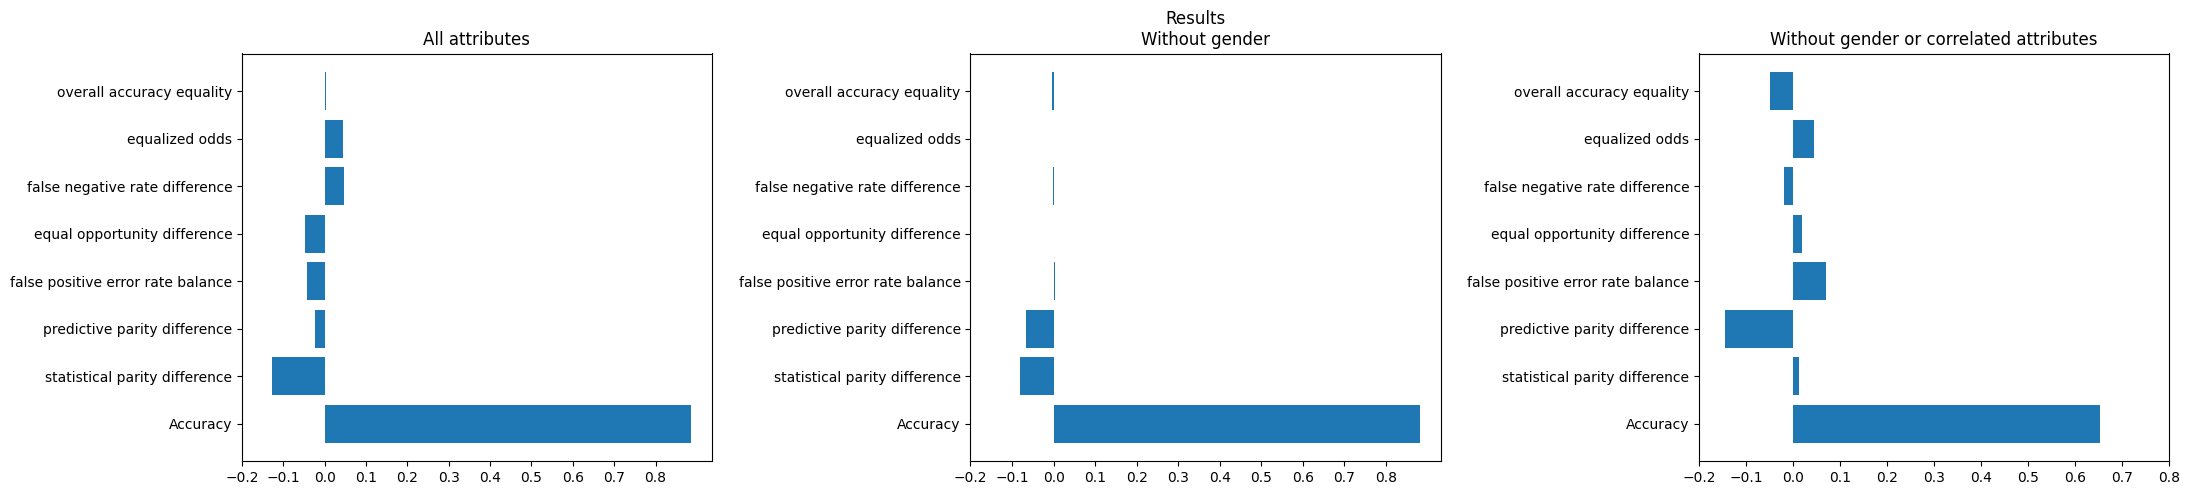

In [33]:
# results_1 = apply_metrics.fair_metrics(res_df_1)
# results_2 = apply_metrics.fair_metrics(res_df_2)
# results_3 = apply_metrics.fair_metrics(res_df_3)

plot_horizontal_dictionaries([final_results_1, final_results_2, final_results_3], title='Results',labels=['All attributes','Without gender','Without gender or correlated attributes'], errors=True)

### 4.3 Fairness without sensitive attributes

In [ ]:
df_state2_processed = process_data_census(df_state2_cleaned)

X_train, X_test, y_train, y_test = split_data(df_state2_processed, test_size = 0.25, y_name = 'Class', get_test = True)

cc = RandomUnderSampler(sampling_strategy=1.0,random_state=2)
X_res, y_res = cc.fit_resample(X_train, y_train)

# Get independent attributes from NY data
dependent_attributes, independent_attributes = apply_categorical_tests(df_cleaned, class_name = 'SEX', alpha = 0.01)
diff_dis_attributes, same_dis_attributes = get_mannwhitneyu(df_cleaned, class_name = 'SEX', alpha = 0.01)

independent_attributes = {**independent_attributes, **same_dis_attributes}

attributes = [k for k,v in independent_attributes.items() if k in X_res.columns] + ['gender']

# Remove attributes related according NY data
X_res_wo_corr = X_res[attributes]
X_test_wo_corr = X_test[attributes]

accuracies = []
auc_scores = []
f1_scores = []
f1_weighted_scores = []
results = []

for i in range(10):
    print(i)

    clf = XGBClassifier(seed=i)
    clf = clf.fit(X_res_wo_corr.loc[:, X_res_wo_corr.columns != 'gender'], y_res)
    y_pred = test_model(clf, X_test_wo_corr.loc[:, X_test_wo_corr.columns != 'gender'])
    
    accuracies.append(metrics.accuracy_score(y_test, y_pred))
    auc_scores.append(metrics.roc_auc_score(y_test, y_pred))
    f1_scores.append(metrics.f1_score(y_test,y_pred))
    f1_weighted_scores.append(metrics.f1_score(y_test, y_pred, average='weighted'))

    res_df = get_res_df(X_test, y_test, y_pred)
    results.append(apply_metrics.fair_metrics(res_df, favorable_class=1))

print('Accuracy: ',sum(accuracies)/len(accuracies),'±', np.std(accuracies))
print('AUC: ',sum(auc_scores)/len(auc_scores),'±', np.std(auc_scores))
print('F1: ',sum(f1_scores)/len(f1_scores),'±', np.std(f1_scores))
print('F1 Weighted: ',sum(f1_weighted_scores)/len(f1_weighted_scores),'±', np.std(f1_weighted_scores))

final_results_4 = {'Accuracy': (sum(accuracies)/len(accuracies),np.std(accuracies))}

for key in results[0].keys():
    print(f'{key}: {sum(r[key] for r in results) / len(results)} ± {np.std([r[key] for r in results])}')
    final_results_4[key] = (sum(r[key] for r in results) / len(results), np.std([r[key] for r in results]))

final_results_4

In [ ]:
plot_horizontal_dictionaries([final_results_1, final_results_3, final_results_4], title='Results',labels=['All attributes NY','Without NY gender related attributes NY','Without NY gender related attributes TX'], errors=True)

## 5. Most related attributes among states

In [5]:
def get_state_data(state, year, clean_data = True, process_data = True, download = True):
    data_source = ACSDataSource(survey_year=year, horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=[state], download=download)
    feature_codes = list(acs_data.columns)
    ACSIncome = BasicProblem(
        features=[feature_codes],
        target='PINCP',
        target_transform=lambda x: x > 50000,    
        group='SEX',
        preprocess=adult_filter,
        postprocess=lambda x: x,
    )
    features, label, group = ACSIncome.df_to_numpy(acs_data)
    df = pd.concat([pd.DataFrame(features), pd.DataFrame(label)], axis=1)
    df.columns = feature_codes + ['TARGET']
    definition_df = data_source.get_definitions(download=True)
    
    if clean_data == True:
        df = clean_df(df, definition_df)
        
    if process_data == True:
        df = process_data_census(df)
        
    return df
    
    

In [6]:
def create_heatmap():
    # Define the list of states
    states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL",
          "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME",
          "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH",
          "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI",
          "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI",
          "WY"]#, "PR"] # Removed: DC (district capital)

    # Define the list of attributes
    with open(f'./results/stats/{states[0]}_attributes_stats.json') as file:
        data = json.load(file)
        attributes = list(data.keys())

    # Initialize an empty dictionary to store the values
    heatmap_values = {}

    # Read and process each file
    for state in states:
        with open(f'./results/stats/{state}_attributes_stats.json') as file:
            data = json.load(file)
            values = [data[attr] for attr in attributes]
            heatmap_values[state] = values

    # Convert the heatmap_values dictionary to a 2D numpy array
    heatmap_array = np.array([heatmap_values[state] for state in states])

    # Set the figure size based on the number of attributes and states
    fig, ax = plt.subplots(figsize=(120, 10))

    # Create the heatmap plot
    heatmap = ax.imshow(heatmap_array, cmap='hot', interpolation='nearest')
    plt.colorbar(heatmap)

    # Set the x-axis and y-axis labels
    plt.xticks(np.arange(len(attributes)), attributes)
    plt.yticks(np.arange(len(states)), states)

    # Rotate x-axis labels if needed
    plt.xticks(rotation=90)


In [7]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL",
          "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME",
          "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH",
          "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI",
          "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI",
          "WY", "PR"] # Removed: DC (district capital)

for state in states:
    # Get state data
    print(state)
    df_cleaned = get_state_data(state, '2018', clean_data = True, process_data = False, download = False)

    dependent_attributes, independent_attributes = apply_categorical_tests(df_cleaned, class_name = 'SEX', alpha = 0.01, verbose = False)
    diff_dis_attributes, same_dis_attributes = get_mannwhitneyu(df_cleaned, class_name = 'SEX', alpha = 0.01)

    stats_results = {**independent_attributes, **same_dis_attributes, **dependent_attributes, **diff_dis_attributes}
    # stats_results = {k: v for k, v in stats_results.items() if not math.isnan(v)}
    stats_results = {k: v for k, v in sorted(stats_results.items(), key=lambda item: item[1], reverse=False)}

    with open(f'./results/stats/{state}_attributes_stats.json', 'w') as outfile:
        json.dump(stats_results, outfile)



AL


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

AK


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

AZ


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

AR


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

CA


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

CO


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

CT


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

DE


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

FL


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

GA


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

HI


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

ID


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

IL


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

IN


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

IA


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

KS


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

KY


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

LA


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

ME


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

MD


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

MA


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

MI


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

MN


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

MS


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

MO


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

MT


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

NE


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

NV


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

NH


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

NJ


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

NM


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

NY


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

NC


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

ND


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

OH


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

OK


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

OR


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

PA


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

RI


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

SC


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

SD


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

TN


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

TX


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

UT


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

VT


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

VA


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

WA


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

WV


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

WI


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

WY


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

PR


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_65607/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q

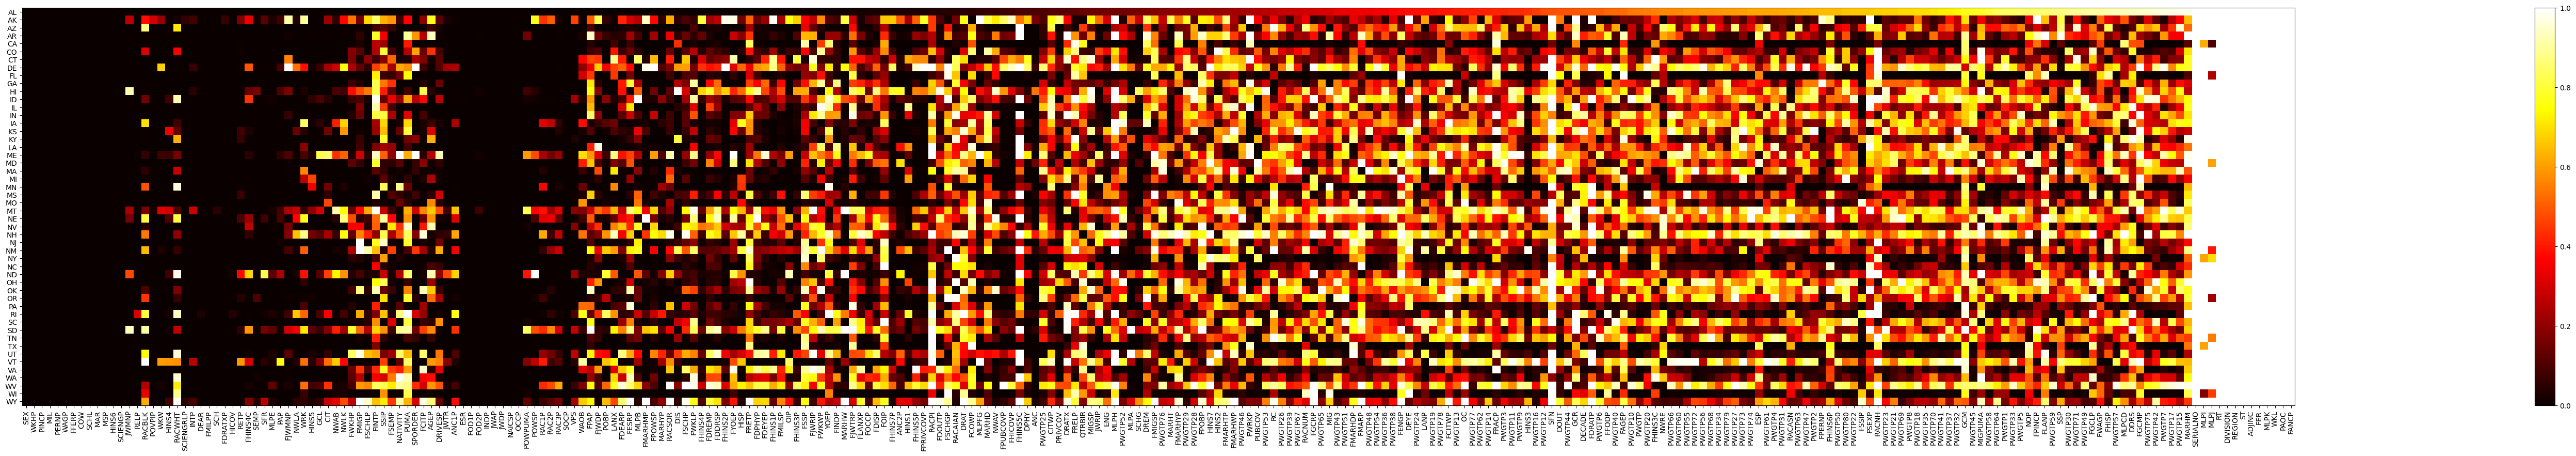

In [8]:
create_heatmap()

## 6. Difference among states

In [7]:
def get_results(accuracies, auc_scores, f1_scores, f1_weighted_scores, results, verbose = True):
    
    if verbose == True:
        print('Accuracy: ',sum(accuracies)/len(accuracies),'±', np.std(accuracies))
        print('AUC: ',sum(auc_scores)/len(auc_scores),'±', np.std(auc_scores))
        print('F1: ',sum(f1_scores)/len(f1_scores),'±', np.std(f1_scores))
        print('F1 Weighted: ',sum(f1_weighted_scores)/len(f1_weighted_scores),'±', np.std(f1_weighted_scores))

    final_results = {'Accuracy': (sum(accuracies)/len(accuracies),np.std(accuracies)),
                     'AUC': (sum(auc_scores)/len(auc_scores),np.std(auc_scores)),
                     'F1': (sum(f1_scores)/len(f1_scores),np.std(f1_scores)),
                     'F1 Weighted': (sum(f1_weighted_scores)/len(f1_weighted_scores),np.std(f1_weighted_scores))}

    for key in results[0].keys():
        if verbose == True:
            print(f'{key}: {sum(r[key] for r in results) / len(results)} ± {np.std([r[key] for r in results])}')
        final_results[key] = (sum(r[key] for r in results) / len(results), np.std([r[key] for r in results]))
        
    return final_results

In [8]:
def save_results(data, file_name):
    with open(file_name, 'w') as outfile:
        json.dump(data, outfile)
    return

In [9]:
def train_all_attributes(X_train, X_test, y_train, y_test, n_iter = 10, verbose = True):

    accuracies = []
    auc_scores = []
    f1_scores = []
    f1_weighted_scores = []
    results = []

    for i in range(n_iter):
        if verbose == True:
            print(i)

        clf = XGBClassifier(seed=i)
        clf = clf.fit(X_train, y_train)
        y_pred = test_model(clf, X_test)

        accuracies.append(metrics.accuracy_score(y_test, y_pred))
        auc_scores.append(metrics.roc_auc_score(y_test, y_pred))
        f1_scores.append(metrics.f1_score(y_test,y_pred))
        f1_weighted_scores.append(metrics.f1_score(y_test, y_pred, average='weighted'))

        res_df = get_res_df(X_test, y_test, y_pred)
        results.append(apply_metrics.fair_metrics(res_df, favorable_class=1))

    return get_results(accuracies, auc_scores, f1_scores, f1_weighted_scores, results, verbose)

In [10]:
def train_without_sensitive(X_train, X_test, y_train, y_test, n_iter = 10, verbose = True):
    accuracies = []
    auc_scores = []
    f1_scores = []
    f1_weighted_scores = []
    results = []

    for i in range(n_iter):
        if verbose == True:
            print(i)
        clf = XGBClassifier(seed=i)
        clf = clf.fit(X_train.loc[:, X_train.columns != 'gender'], y_train)
        y_pred = test_model(clf, X_test.loc[:, X_test.columns != 'gender'])

        accuracies.append(metrics.accuracy_score(y_test, y_pred))
        auc_scores.append(metrics.roc_auc_score(y_test, y_pred))
        f1_scores.append(metrics.f1_score(y_test,y_pred))
        f1_weighted_scores.append(metrics.f1_score(y_test, y_pred, average='weighted'))

        res_df = get_res_df(X_test, y_test, y_pred)
        results.append(apply_metrics.fair_metrics(res_df, favorable_class=1))
    
    return get_results(accuracies, auc_scores, f1_scores, f1_weighted_scores, results, verbose)

In [11]:
def train_without_related(df_cleaned, X_train, X_test, y_train, y_test, n_iter = 10, verbose = True, alpha = 0.01, load_state_attributes = None):
    
    if load_state_attributes == None:
        dependent_attributes, independent_attributes = apply_categorical_tests(df_cleaned, class_name = 'SEX', alpha = alpha, verbose = verbose)
        diff_dis_attributes, same_dis_attributes = get_mannwhitneyu(df_cleaned, class_name = 'SEX', alpha = alpha)

        independent_attributes = {**independent_attributes, **same_dis_attributes}
    else:
        with open(f'./results/stats/{load_state_attributes}_attributes_stats.json') as file:
            data = json.load(file)
            independent_attributes = {key: value for key, value in data.items() if value > alpha}

    attributes = [k for k,v in independent_attributes.items() if k in X_res.columns] + ['gender']

    X_res_wo_corr = X_res[attributes]
    X_test_wo_corr = X_test[attributes]

    accuracies = []
    auc_scores = []
    f1_scores = []
    f1_weighted_scores = []
    results = []

    for i in range(n_iter):
        if verbose == True:
            print(i)

        clf = XGBClassifier(seed=i)
        clf = clf.fit(X_res_wo_corr.loc[:, X_res_wo_corr.columns != 'gender'], y_res)
        y_pred = test_model(clf, X_test_wo_corr.loc[:, X_test_wo_corr.columns != 'gender'])

        accuracies.append(metrics.accuracy_score(y_test, y_pred))
        auc_scores.append(metrics.roc_auc_score(y_test, y_pred))
        f1_scores.append(metrics.f1_score(y_test,y_pred))
        f1_weighted_scores.append(metrics.f1_score(y_test, y_pred, average='weighted'))

        res_df = get_res_df(X_test, y_test, y_pred)
        results.append(apply_metrics.fair_metrics(res_df, favorable_class=1))
        
    return get_results(accuracies, auc_scores, f1_scores, f1_weighted_scores, results, verbose)

In [ ]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL",
          "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME",
          "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH",
          "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI",
          "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI",
          "WY", "PR"] # Removed: DC (district capital)

for state in states:
    # Get state data
    df_cleaned = get_state_data(state, '2018', clean_data = True, process_data = False, download = False)
    df_processed = process_data_census(df_cleaned)
    X_train, X_test, y_train, y_test = split_data(df_processed, test_size = 0.25, y_name = 'Class', get_test = True)
    cc = RandomUnderSampler(sampling_strategy=1.0,random_state=2)
    X_res, y_res = cc.fit_resample(X_train, y_train)

    # Apply experiments
    res1 = train_all_attributes(X_res, X_test, y_res, y_test, n_iter = 3, verbose = False)
    res2 = train_without_sensitive(X_res, X_test, y_res, y_test, n_iter = 3, verbose = False)
    res3 = train_without_related(df_cleaned, X_res, X_test, y_res, y_test, n_iter = 3, verbose = False, load_state = state)

    # Save results
    save_results([res1, res2, res3], file_name = f'./results/model_results/{state}_model_results.json')
    # Plot results
    plot_horizontal_dictionaries([res1, res2, res3], title=f'Results {state}',labels=['All attributes','Without gender','Without gender related attributes'], errors=True)

### 6.2. Transfer sensitive information between states

In [12]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL",
          "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME",
          "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH",
          "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI",
          "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI",
          "WY"]

for state in states:
    print(state)
    #Create folder
    try:
        os.mkdir(f'./results/transfer_results/{state}')
    except:
        pass

    # Get state data
    df_cleaned = get_state_data(state, '2018', clean_data = True, process_data = False, download = False)
    df_processed = process_data_census(df_cleaned)
    X_train, X_test, y_train, y_test = split_data(df_processed, test_size = 0.25, y_name = 'Class', get_test = True)
    cc = RandomUnderSampler(sampling_strategy=1.0,random_state=2)
    X_res, y_res = cc.fit_resample(X_train, y_train)

    # Apply experiments
    for s in states:
        results = train_without_related(df_cleaned, X_res, X_test, y_res, y_test, n_iter = 3, verbose = False, load_state_attributes = s)
        # Save results
        save_results(results, file_name = f'./results/transfer_results/{state}/{s}_attributes_in_{state}_data.json')
   

PA


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3

RI


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3

SC


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3

SD


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3

TN


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3

TX


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3

UT


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3

VT


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3

VA


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3

WA


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3

WV


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3

WI


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3

WY


/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return definition_df[definition_df[0] == 'NAME'][definition_df[1] == col_name].iloc[0][2]
/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_6466/2764117932.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  values_df = definition_df[definition_df[0] == 'VAL'][definition_df[1] == col_name]
/var/folders/q1/s3

In [ ]:
StopHere

## 7. Correlation removal experiments

In [ ]:
df_cleaned = get_state_data('NY', '2018', clean_data = True, process_data = False, download = True)
df_cleaned

In [ ]:
dependent_attributes, independent_attributes = apply_categorical_tests(df_cleaned, class_name = 'SEX', alpha = 0.01)
diff_dis_attributes, same_dis_attributes = get_mannwhitneyu(df_cleaned, class_name = 'SEX', alpha = 0.01)

dependent_attributes = {**dependent_attributes, **diff_dis_attributes}
dependent_attributes

In [ ]:
from fairlearn.preprocessing import CorrelationRemover

df_processed = process_data_census(df_cleaned)
da_list = [k for k in dependent_attributes.keys() if k in df_processed.columns] + ['gender']

df_dependent = df_processed[da_list]

cr = CorrelationRemover(sensitive_feature_ids=['gender'], alpha=1.0)
cr.fit(df_dependent)
df_transform = cr.transform(df_dependent)
df_transform = pd.DataFrame(df_transform, columns = [d for d in da_list if d != 'gender'])

df_processed[df_transform.columns] = df_transform

X_train, X_test, y_train, y_test = split_data(df_processed, test_size = 0.25, y_name = 'Class', get_test = True)
cc = RandomUnderSampler(sampling_strategy=1.0,random_state=2)
X_res, y_res = cc.fit_resample(X_train, y_train)

res_CR_sa = train_without_sensitive(X_res, X_test, y_res, y_test, n_iter = 3, verbose = False)
res_CR_sa

In [ ]:
# Get state data
df_cleaned = get_state_data('NY', '2018', clean_data = True, process_data = False, download = True)
df_processed = process_data_census(df_cleaned)

X = df_processed.drop('Class', axis=1)
y = df_processed['Class']

cr = CorrelationRemover(sensitive_feature_ids=['gender'], alpha=1.0)
cr.fit(X)
X_transform = cr.transform(X)
X_transform = pd.DataFrame(X, columns = [d for d in X.columns if d != 'gender'])
X[X_transform.columns] = X_transform

df_processed = pd.concat([X, y], axis=1)

X_train, X_test, y_train, y_test = split_data(df_processed, test_size = 0.25, y_name = 'Class', get_test = True)

cc = RandomUnderSampler(sampling_strategy=1.0,random_state=2)
X_res, y_res = cc.fit_resample(X_train, y_train)

res_CR_all = train_without_sensitive(X_res, X_test, y_res, y_test, n_iter = 3, verbose = False)
res_CR_all

In [ ]:
# Get state data
df_cleaned = get_state_data('NY', '2018', clean_data = True, process_data = False, download = True)
df_processed = process_data_census(df_cleaned)
X_train, X_test, y_train, y_test = split_data(df_processed, test_size = 0.25, y_name = 'Class', get_test = True)
cc = RandomUnderSampler(sampling_strategy=1.0,random_state=2)
X_res, y_res = cc.fit_resample(X_train, y_train)

# Apply experiments
res1 = train_all_attributes(X_res, X_test, y_res, y_test, n_iter = 3, verbose = False)
res2 = train_without_sensitive(X_res, X_test, y_res, y_test, n_iter = 3, verbose = False)
res3 = train_without_related(df_cleaned, X_res, X_test, y_res, y_test, n_iter = 3, verbose = False)

# Plot results
plot_horizontal_dictionaries([res1, res2, res3], title=f'Results NY',labels=['All attributes','Without gender','Without gender related attributes'], errors=True)

In [ ]:
plot_horizontal_dictionaries([res1, res_CR_all, res_CR_sa], title=f'Results NY',labels=['All attributes','With Correlation remover','With correlation remover just in related attributes'], errors=True)

In [ ]:
# Plot results
plot_horizontal_dictionaries([res1, res3, res_CR_all], title=f'Results {state}',labels=['All attributes','Without gender related attributes','With correlation remover'], errors=True)